In [36]:
import numpy as np
import pandas as pd 
import geopandas as gpd
import hvplot as hv
import hvplot.pandas
import sys, os
import pickle
import matplotlib.pyplot as plt
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))  # parent of notebooks
if project_root not in sys.path:
    sys.path.append(project_root)
    
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score,balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, root_mean_squared_error, mean_absolute_error, mean_squared_error

from src.util.model import eval_model, prep_data
seed = 42

In [2]:
dff0 = pd.DataFrame()

data_fp = "../../data/training_data"
for fn in os.listdir(data_fp):
    df = pd.read_csv(os.path.join(data_fp, fn))
    print(f"{fn} {df.shape}")
    dff0 = pd.concat([dff0, df])
print(dff0.shape)

snow_2020-2025_p134_fxx1.csv (116216, 68)
snow_2020-2025_p198_fxx1.csv (145920, 68)
snow_2020-2025_p192_fxx1.csv (145920, 68)
snow_2020-2025_p193_fxx1.csv (145920, 68)
snow_2020-2025_p202_fxx1.csv (145920, 68)
snow_2020-2025_p153_fxx1.csv (145920, 68)
snow_2020-2025_p182_fxx1.csv (145920, 68)
snow_2020-2025_p183_fxx1.csv (145920, 68)
snow_2020-2025_p186_fxx1.csv (145920, 68)
snow_2020-2025_p121_fxx1.csv (145920, 68)
snow_2020-2025_p207_fxx1.csv (145920, 68)
snow_2020-2025_p206_fxx1.csv (145920, 68)
snow_2020-2025_p105_fxx1.csv (145920, 68)
snow_2020-2025_p200_fxx1.csv (145920, 68)
snow_2020-2025_p119_fxx1.csv (145920, 68)
snow_2020-2025_p151_fxx1.csv (145920, 68)
(2305016, 68)


In [39]:
danger_levels = pd.read_csv("../../../data/FAC/FAC_Danger_rating_zone_elv.csv")
danger_levels['date'] = pd.to_datetime(danger_levels['date'])
danger_levels = danger_levels[danger_levels['danger_rating'] > -1]
danger_levels = danger_levels.drop_duplicates(subset=['date','danger_rating','forecast_zone_id'])
print(danger_levels.shape)
print(danger_levels.head())

(2043, 7)
        date      id  danger_rating forecast_zone_id  lower  upper  middle
0 2025-04-07  166257              2        whitefish      1      2       2
1 2025-04-07  166257              2             swan      1      2       2
2 2025-04-07  166257              2         flathead      1      2       2
3 2025-04-06  166196              3        whitefish      1      3       3
4 2025-04-06  166196              3             swan      1      3       3


In [49]:
X, y, excluded_cols = prep_data(
    dff0, 
    danger_levels, 
    replace_missing=True, 
    # change_danger=True,
    exclude_cols=['date','id','slope_azi', 'danger_level','altitude','slope_angle','forecast_zone_id','elevation_band']) 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=seed)

In [51]:
# Params found from tuning
# {'class_weight': 'balanced', 
#  'max_depth': 50, 
#  'max_features': 0.5, 
#  'min_samples_leaf': 4, 
#  'min_samples_split': 20, 
#  'n_estimators': 1000}


rf = RandomForestClassifier(random_state=seed, n_jobs=-1,
                            max_depth=50,
                            max_features=0.5,
                            min_samples_leaf=4,
                            min_samples_split=20,
                            n_estimators=500,
                            class_weight='balanced'
                           )


rf.fit(X_train, y_train)
# with open("../../data/models/best_model.pkl", "rb") as file:
#     rf = pickle.load(file)

,n_estimators,500
,criterion,'gini'
,max_depth,50
,min_samples_split,20
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,0.5
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Train
Accuracy 0.95
Balanced Accuracy 0.96
MAE: 0.058623130696398545
Test
Accuracy 0.87
Balanced Accuracy 0.89
MAE: 0.14101372974088985


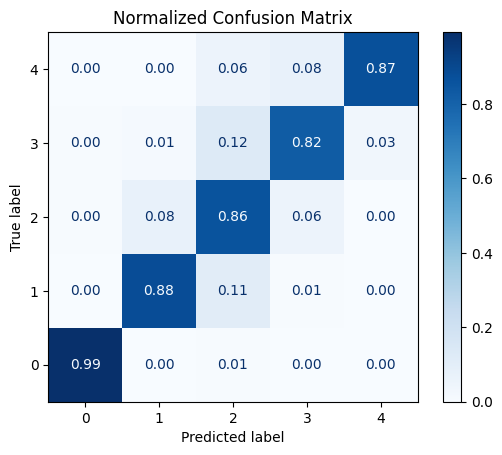

In [54]:
y_pred = rf.predict(X_test)

print("Train")
eval_model(y_train, rf.predict(X_train))

print("Test")
eval_model(y_test, y_pred, plot=True, norm=True)

In [55]:
test_data = pd.concat([X_test,excluded_cols.iloc[X_test.index]],axis=1)
test_data['predicted'] = y_pred
test_data.head()

,id_x,Qs,Ql,Qg,TSG,Qg0,Qr,dIntEnergySnow,meltFreezeEnergySnow,ColdContentSnow,...,zS5,S5,date,altitude,slope_angle,slope_azi,forecast_zone_id,elevation_band,danger_level,predicted
19070,192,-1.328208,-8.096283,0.0,-15.170708,-4.663992,0.0,-15.281442,4.171733e+00,-4.835250,...,0.0,0.004158,2023-03-17,1948.0,30.4,108.0,flathead,middle,2,2
15301,119,4.109125,-8.730492,0.0,-6.766000,-2.898975,0.0,-28.353733,-5.640058e+00,-1.338617,...,0.0,0.005250,2022-12-29,1920.0,30.4,108.0,swan,middle,3,2
6538,134,46.440925,-4.229383,0.0,-5.413692,-5.524200,0.0,45.197083,4.668620e+01,-2.459083,...,0.0,0.303658,2021-03-04,1989.6,30.4,108.0,swan,upper,3,4
9774,105,5.103767,-3.632842,0.0,-17.421417,1.305733,0.0,4.406842,-7.401487e-17,-3.872033,...,0.0,0.000450,2022-01-06,1757.7,30.4,108.0,whitefish,middle,2,3
7438,207,4.944717,-12.803242,0.0,-8.177708,0.758200,0.0,3.966242,0.000000e+00,-12.713417,...,0.0,0.000000,2021-03-22,2259.6,30.4,108.0,swan,upper,2,2


In [56]:
cols = ['elevation_band', 'forecast_zone_id']
for c in cols:
    print(c)
    for v in test_data[c].unique():
        fdf = test_data[test_data[c] == v]
        
        print(v)
        print(accuracy_score(fdf['danger_level'],fdf['predicted']))
    print()

elevation_band
middle
0.8696498054474708
upper
0.8759723422644771
lower
0.8647302904564316

forecast_zone_id
flathead
0.8784989234081821
swan
0.8690513219284604
whitefish
0.8640173859049984



In [57]:
feature_importances = pd.DataFrame(rf.feature_importances_,index = X_train.columns, columns=["importance"]).sort_values(by="importance", ascending=False)
print(feature_importances[feature_importances['importance'] > 0])

                      importance
mAlbedo                 0.115665
ISWR_diff               0.053374
TA                      0.042880
HS_mod                  0.041573
SWE                     0.037173
OLWR                    0.034684
TSS_mod                 0.031010
HN72_24                 0.029255
wind_trans24            0.027893
dIntEnergySnow          0.026583
RH                      0.025689
MS_Water                0.021687
pAlbedo                 0.019540
ISWR_h                  0.019524
ISWR_dir                0.019322
ILWR                    0.018295
DW                      0.016993
S5                      0.016262
HS_meas                 0.016094
Qg0                     0.015515
ISWR                    0.015449
ski_pen                 0.014852
LWR_net                 0.014310
S4                      0.014151
MS_Evap                 0.013703
zSn                     0.013602
Ql                      0.013110
VW_drift                0.013015
Qs                      0.012999
VW        

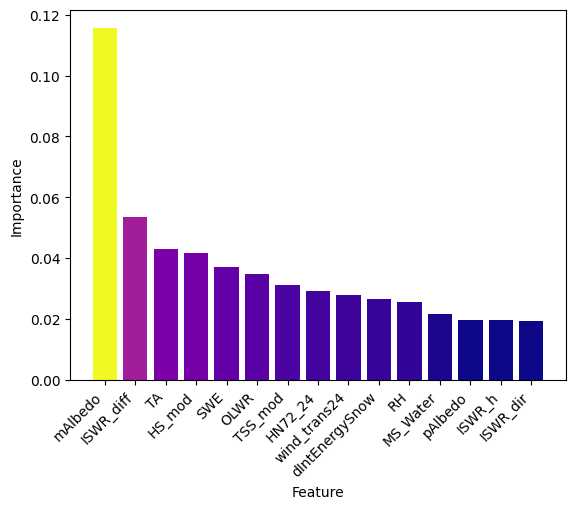

In [58]:
top = feature_importances.iloc[:15]
 
# Normalize and create colors
norm = plt.Normalize(top['importance'].min(), top['importance'].max())
cmap = plt.cm.plasma
colors = cmap(norm(top['importance']))

# Create figure and axes
fig, ax = plt.subplots()

bars = ax.bar(top.index, top['importance'], color=colors)

# Add colorbar — note the ax parameter
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Required for colorbar
# fig.colorbar(sm, ax=ax, label='Importance')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()

In [59]:

with open("../../data/models/best_model.pkl", "ab") as file:
    pickle.dump(rf, file)
    
# with open("../../data/models/best_model.pkl", "rb") as file:
#     best_model = pickle.load(file)
    
# y_pred = best_model.predict(X_test)

# print("Train")
# eval_model(y_train, best_model.predict(X_train))

# print("Test")
# eval_model(y_test, y_pred, plot=True, norm=True)